# Multi-label with Regularization approach 

In this notebook, we will how to implement a simple example of SBR in a multi-label context with hierarchical structure. 

### Example: 
We simulate a data set that consists of images of geometric shapes: circles, triangles and squares. At the same time, each sample will be 
categorized as polygon (all triangles and squares) or curved shape (all circles).
Then, each sample will be labeled with a corresponding 5-dimensional vector. This vector will have:
- a 1 in the first position if the sample is a circle
- a 1 in the second position if the sample is a square
- a 1 in the third position if the sample is a triangle
- a 1 in the fourth position if the sample is a curved shape
- a 1 in the fifth position if the sample is a polygon


We will simulate some data, code a semantic loss and compare results depending on the alpha coefficient.


In [2]:
import torch 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

from modular import extra_functions as ef
from modular import model_builder

Let's start by defining some functions to simulate the multi-label data

In [3]:
def generate_multilabel_sample(
    n , 
    noise_prop,
    seed=999,
    size=28, 
    var=0.15,
    noise_indx = False
    ):
    
    """Generates multi-label samples.

     Args:
        n: vector, number of elements of each class
        noise_prop: proportion of the data with noise
        seed: seed to perform the simulation. Default = 999.
        size: size of the image as number of pixels.
        var: variance for the Gaussian Error. Default = 0.15.
               
    Returns:
        A Dictionary of Arrays of images and labels simulated.
        In the form (images, lables)
    
  """
    dataset_circles = []
    dataset_squares = []
    dataset_triangles = []
        
    ntot = sum(n)
    n_cr = n[0]
    n_sq = n[1]
    n_tr = n[2]
                    
    # Create circles
    for _ in range(n_cr):
        radius = np.random.randint(2, size // 2)  #
        image = ef.draw_circle(size, radius)
        dataset_circles.append(image)
                        
    # Create squares
    for _ in range(n_sq):
        len_size = np.random.randint(2, size)  
        image = ef.draw_square(size, len_size)
        dataset_squares.append(image)
        
    # Create triangles
    for _ in range(n_tr):
        len_size = np.random.randint(2, size )  
        image = ef.draw_triangle(size, len_size)
        dataset_triangles.append(image)
                        
    ## Add noise to some of them
    np.random.seed(seed)
     
    # circles      
    noisy_indices_c = np.random.choice(
        a=n_cr, 
        size=int(n_cr * noise_prop), 
        replace=False
        )
    
    for i in noisy_indices_c: 
        dataset_circles[i] = ef.add_gaussian_noise(dataset_circles[i],var=var)
        
    # squares
    noisy_indices_s = np.random.choice(
        a=n_sq, 
        size=int(n_sq * noise_prop), 
        replace=False
        )
    for i in noisy_indices_s:
        dataset_squares[i] = ef.add_gaussian_noise(dataset_squares[i],var=var)
        
    # triangles
    noisy_indices_is = np.random.choice(
        a=n_tr, 
        size=int(n_tr * noise_prop), 
        replace=False
        )
    for i in noisy_indices_is:
        dataset_triangles[i] = ef.add_gaussian_noise(dataset_triangles[i],var=var)
       
    # Crete dictionary 
    class_to_indx = dict(
        zip(['circles','squares','triangles','curved','Polygons'],
        [0,1,2,3,4,5])
        )
    
    # Create labels
    size = (ntot,5)
    labels = np.zeros(size)
    labels[0:n_cr,(0,3)] = 1
    labels[n_cr:(n_cr+n_sq),(1,4)] = 1
    labels[(n_cr+n_sq):(n_cr+n_sq)+n_tr,(2,4)] = 1
    
    # # Combine datasets
    all_images = np.concatenate(
        (dataset_circles , 
         dataset_squares,
         dataset_triangles)
        )
    
    # Covert to three channels
    all_images_3c = []
    for i in range(len(all_images)):
        all_images_3c.append(np.stack([all_images[i]] * 3, axis=0))
                                       
    # Shuffle the dataset
    indices = np.arange(len(all_images))
    np.random.seed(seed)
    np.random.shuffle(indices)
    all_images_3c = [all_images_3c[i] for i in indices]
    labels = labels[indices]
    output = {
        "images": all_images_3c,
        "labels": labels,
        "class_to_indx": class_to_indx
        }    
    return output

Now we define a class of MultilabelDataSet

In [4]:
from torch.utils.data import Dataset

class MultilabelDataSet(Dataset):
    def __init__(self,images,labels,transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)    
    
    def __getitem__(self, idx):
        # Load image
        image = self.images[idx]
        
        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
            
        #Get label
        label = self.labels[idx]    
        
        return image, label      
        

Let's now simulate some data.  We will generate 1000 samples for each class, with 80% of the including Gaussian noise with a variance of 0.2. 

In [5]:
data = generate_multilabel_sample(n=[1000] * 3, noise_prop=0.8, var=0.2)
data_class = MultilabelDataSet(data['images'],data['labels'])

Let's plot some images

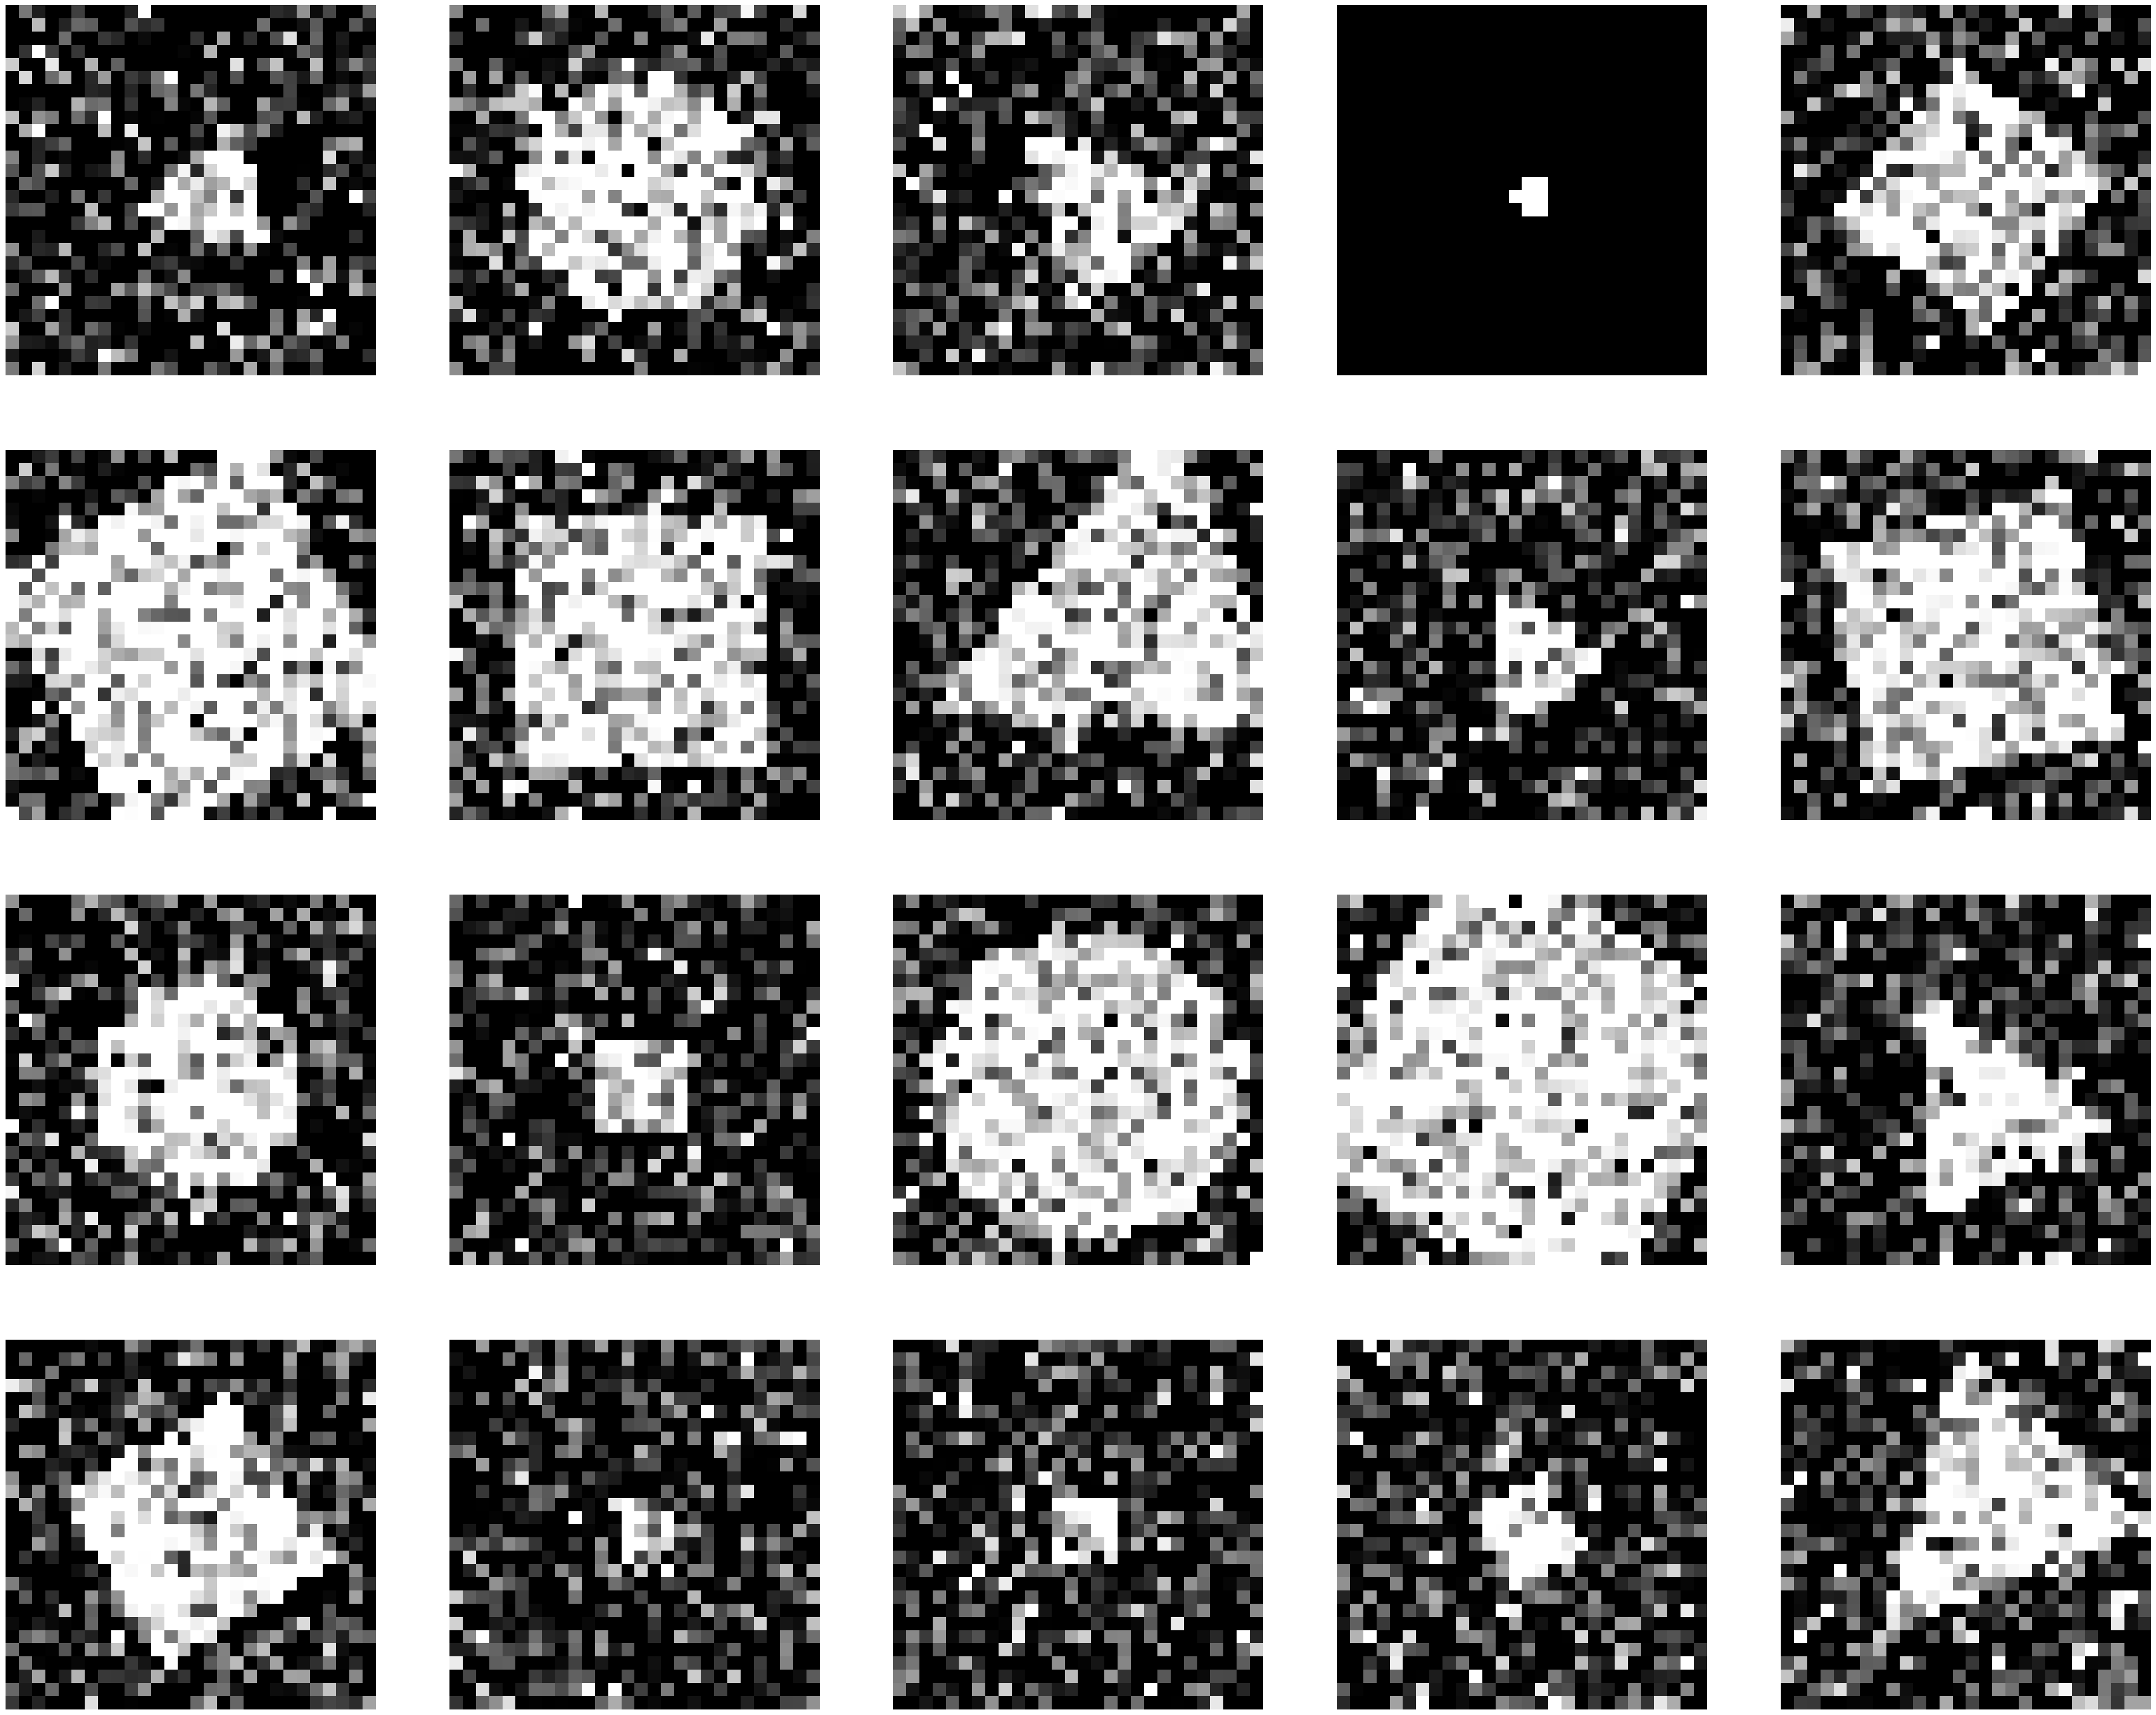

In [ ]:
# Plot some samples
fig, axes = plt.subplots(4, 5, figsize=(50,40))
    
# Flatten the axes array for easier looping
axes = axes.flatten()
    
# Loop through images and axes
for i in range(20):
    axes[i].imshow(data['images'][i][0,:,:], cmap='gray')
    axes[i].axis('off')  

Now we define the regularization loss, which penalizes samples that are simultaneously classified as both triangle and curved, square and curved, or circle and polygon. 

In [7]:
def reg_loss(y_hat, coef_lambda=None):
    """
    Implements the semantic rule:
    TRIANGLE(x) ⇒ ¬ CURVED(x)
    SQUARE(x) ⇒ ¬ CURVED(x)
    CIRCLE(x) ⇒ ¬ POLYGON(x)
    
    Args:
        y_hat (Tensor): vector containing the model's output
        coef_lambda (list): OPTIONAL, coefficients for each violation
       
    Returns: 
            float: the value of the regularized loss function 
    """
    
    if coef_lambda is None:
        coef_lambda = [1,1,1]
        
    out_sigmoid = torch.sigmoid(y_hat)
    circles = out_sigmoid[:,0]
    squares = out_sigmoid[:,1]
    triangles = out_sigmoid[:,2]
    curved = out_sigmoid[:,3]
    polygons = out_sigmoid[:,4]
        
    violation1 = torch.mean(circles * polygons)
    violation2 = torch.mean(squares * curved)
    violation3 = torch.mean(triangles * curved)
    
    reg_term = (
        coef_lambda[0]*violation1  
        + coef_lambda[1]*violation2 
        + coef_lambda[2]*violation3 
        )  
    
    return reg_term

We now define the training and validation loops for the model, adding the regularization loss

In [9]:
def train_val_loop(
    EPOCHS,
    model,
    train_dataloader,
    val_dataloader, 
    device,
    optimizer,
    reg_fn,
    alpha
    ):
    
    """Trains and validates a PyTorch model including regularization function.

    Args:
        EPOCHS: number of epochs to run
        model: A PyTorch model to be trained.
        train_dataloader: A DataLoader instance for the model to be trained on.
        val_dataloader: A DataLoader instance for the model to be validated on.
        device: torch.device
        optimizer: A PyTorch optimizer to help minimize the loss function.
        reg_fn: regularization function
        alpha: alpha coefficient for the regularization term
 
    Returns:
        training loss and validation loss.
        In the form (training_loss, validation_loss)
    
  """
    epoch_train_loss = []
    epoch_val_loss = []
    
    # Train Model
    for epoch in range(EPOCHS):
        train_losses = []
        model.train()
        for batch,(X, y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            X = X.to(device,dtype = torch.float)
            y = y.to(device,dtype = torch.float)
            y_hat = model(X)
            error = nn.BCEWithLogitsLoss()
            loss = (
                torch.sum(error(y_hat,y)) + 
                alpha * reg_fn(y_hat, coef_lambda=[1,.2,.2])
                )
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            
        epoch_train_loss.append(np.mean(train_losses))
        
        # Validation step
        val_losses = []
        model.eval()
        with torch.no_grad():
            for batch,(X, y) in enumerate(val_dataloader):
                X = X.to(device,dtype = torch.float)
                y = y.to(device,dtype = torch.float)
                y_hat = model(X)
                error = nn.BCEWithLogitsLoss()
                loss = torch.sum(error(y_hat,y)) + alpha * reg_loss(y_hat)
                val_losses.append(loss.item())
        epoch_val_loss.append(np.mean(val_losses))
        
        if epoch%10==0:
            print(
                'Train Epoch: {}\t Train Loss: {:.6f}\t Val Loss: {:.6f}'.format(
                    epoch+1,
                    np.mean(train_losses),
                    np.mean(val_losses))               
                )      
            
    return(epoch_train_loss,epoch_val_loss)     

Nice!, Let's now prepare the dataset for input into the model. We'll split it into train, validation and test.

In [10]:
# Set sets sizes
train_size = int(0.7 * len(data_class.labels))
val_size = int(0.10 * len(data_class.labels))
test_size = len(data_class.labels) - train_size - val_size

# Split dataset
seed = 45
generator = torch.Generator().manual_seed(seed)
train_dataset, val_dataset, test_dataset = random_split(
    data_class, 
    [train_size, val_size, test_size],
    generator=generator
    )

# Generate dataloaders
BATCH_SIZE = 50

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    generator=generator 
    )

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False
    )

test_dataloader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False
    )

We now define the model and the optimizer. We will use the tinyVGG architecture

In [11]:
model = model_builder.TVGG(
    input_shape=3,  
    hidden_units=10, 
    output_shape=5
    )

eta = 0.001
optimizer = torch.optim.Adam(params=model.parameters(), lr=eta)

We now train the model with alpha = 0, meaning NO regularization term 

In [12]:
EPOCHS = 40
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_loss, val_loss = train_val_loop(
    EPOCHS=EPOCHS, 
    model=model, 
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader, 
    device=device,
    optimizer=optimizer,
    reg_fn=reg_loss,
    alpha=0
    )

Train Epoch: 1	 Train Loss: 0.647179	 Val Loss: 0.628382
Train Epoch: 11	 Train Loss: 0.230717	 Val Loss: 0.274474
Train Epoch: 21	 Train Loss: 0.148742	 Val Loss: 0.195022
Train Epoch: 31	 Train Loss: 0.127658	 Val Loss: 0.205579


Let's plot the losses

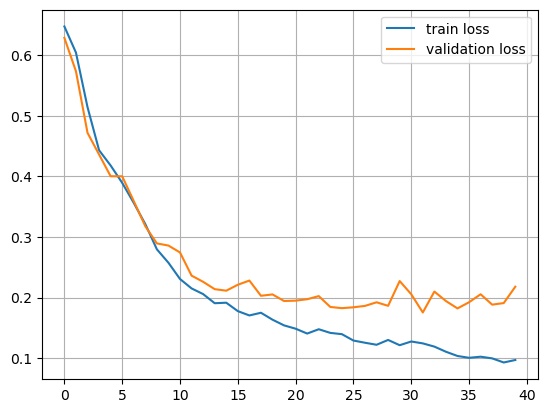

In [13]:
plt.plot(train_loss,label='train loss')
plt.plot(val_loss,label='validation loss')
plt.grid()
plt.legend()
plt.show()

Now is time to evaluate how the trained model performs on the test dataset. To do this, we first define a function that predicts the class of new samples. 
Each sample is associated with two categories, one from {circle, square, triangle} and another from {curved shape, polygon}. We'll predict the two classes with the highest confidence scores. 

In [17]:
def get_predictions(model,image):
         
    """Calculates predictions from a trained multi-label PyTorch model. It takes 
    the two categories with largest confidence.  
    
    Args:
        model: A PyTorch trained model 
        image: new sample to be predicted  
    
    Returns:
        predictions and confidence 
    
  """
    out = model(image)
    probs = torch.sigmoid(out)
    # to get predictions by threshold
    # preds = (probs>thr).float()
    # to get predictions by top 2
    preds = torch.zeros_like(probs)  
    topk = torch.topk(probs, k=2, dim=1)  
    topk_indices = topk.indices   
    preds.scatter_(1, topk_indices, 1.0)    
     
    return preds, probs


def test_loop(model,dataloader):
    
    """Generate predictions for samples in the test Dataloader from a trained 
    multi-label model   
   
    Args:
        model: A PyTorch trained model 
        dataloader: Test dataloader to be predicted  
    
    Returns:
        lists of real labels, predicted labels and confidence 
    
    """
    
    real_labels = []
    pred_labels = []
    probs_labels = []
    with torch.no_grad():
        for batch,(X, y) in enumerate(dataloader):
                X = X.to(device,dtype = torch.float)
                y = y.to(device,dtype = torch.float)
                preds, probs = get_predictions(model,X)
                pred_labels.append(preds)
                probs_labels.append(probs)
                real_labels.append(y)
            
    return real_labels, pred_labels, probs_labels    

Now we apply the previous function to our test data and trained model

In [18]:
real_labels, pred_labels, probs_labels = test_loop(
    model = model,
    dataloader = test_dataloader
    )

Let's calculate the accuracy, precision, recall and F1 score using the `Multilabel` metric functions from `torchmetrics` 

In [19]:
from torchmetrics.classification import (
    MultilabelAccuracy, 
    MultilabelPrecision, 
    MultilabelRecall,
    MultilabelF1Score
    )
accuray_metric = MultilabelAccuracy(num_labels=5)
precision_score = MultilabelPrecision(num_labels=5)
recall_score = MultilabelRecall(num_labels=5)
f1_score = MultilabelF1Score(num_labels=5)

all_probs = torch.cat(probs_labels, dim=0)  
all_true_labels = torch.cat(real_labels, dim=0)
all_pred_labels = torch.cat(pred_labels, dim=0)

print('Overeall accuracy:', accuray_metric(all_probs, all_true_labels).numpy())
print('Precision:', precision_score(all_probs, all_true_labels).numpy())
print('Recall:', recall_score(all_probs, all_true_labels).numpy())
print('F1:', f1_score(all_probs, all_true_labels).numpy())

Overeall accuracy: 0.8903333
Precision: 0.8673811
Recall: 0.83698845
F1: 0.85078937


Next, we'll examine how many samples were assigned to contradictory classes

In [20]:
# Check for contradictions
pred_numpy = torch.stack(pred_labels).cpu().numpy()
real_numpy = torch.stack(real_labels).cpu().numpy()

# Polygon and circles
print(
      'Circles and polygons:', 
      np.sum(np.all(pred_numpy == np.array([1,0,0,0,1]), axis=2))
)

# curved and squares
print(
      'Curved and squares:',
      np.sum(np.all(pred_numpy == np.array([0,1,0,1,0]), axis=2))
)

# Curved and triangles
print(
      'Curved and triangles:',
      np.sum(np.all(pred_numpy == np.array([0,0,1,1,0]), axis=2))
)


Circles and polygons: 8
Curved and squares: 3
Curved and triangles: 0


We now train the model, but this time with $\alpha>0$

In [26]:
model_reg = model_builder.TVGG(
    input_shape = 3,  
    hidden_units= 10, 
    output_shape = 5
    )
eta = 0.001
optimizer = torch.optim.Adam(params = model_reg.parameters(), lr=eta)

In [27]:
train_loss_reg, val_loss_reg = train_val_loop(
    EPOCHS=EPOCHS, 
    model=model_reg, 
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader, 
    device=device,
    optimizer=optimizer,
    reg_fn=reg_loss,
    alpha=0.1
    )

Train Epoch: 1	 Train Loss: 0.674958	 Val Loss: 0.676304
Train Epoch: 11	 Train Loss: 0.325936	 Val Loss: 0.327646
Train Epoch: 21	 Train Loss: 0.193528	 Val Loss: 0.193911
Train Epoch: 31	 Train Loss: 0.150907	 Val Loss: 0.171961


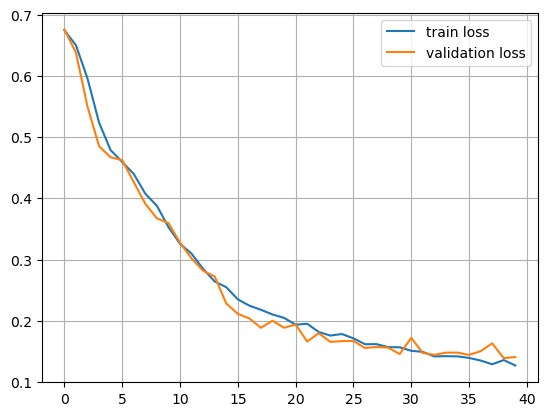

In [28]:
plt.plot(train_loss_reg,label='train loss')
plt.plot(val_loss_reg,label='validation loss')
plt.grid()
plt.legend()
plt.show()

Let's test the model on the test dataset

In [30]:
real_labels_reg, pred_labels_reg, probs_labels_reg = test_loop(
    model=model_reg,
    dataloader=test_dataloader
    )

all_probs_reg = torch.cat(probs_labels_reg, dim=0)  
all_true_labels_reg = torch.cat(real_labels_reg, dim=0)
all_pred_labels_reg = torch.cat(pred_labels_reg, dim=0)

print('Overeall accuracy:', accuray_metric(all_probs_reg, all_true_labels_reg).numpy())
print('Precision:', precision_score(all_probs_reg, all_true_labels_reg).numpy())
print('Recall:', recall_score(all_probs_reg, all_true_labels_reg).numpy())
print('F1:', f1_score(all_probs_reg, all_true_labels_reg).numpy())

Overeall accuracy: 0.8896667
Precision: 0.86798614
Recall: 0.830889
F1: 0.8474359


We got similar metrics than before. Let's see if the number of contradictions has decreased

In [31]:
# Check for contradictions
pred_numpy = torch.stack(pred_labels_reg).cpu().numpy()
real_numpy = torch.stack(real_labels_reg).cpu().numpy()

# Polygon and circles
print(
      'Circles and polygons:', 
      np.sum(np.all(pred_numpy == np.array([1,0,0,0,1]), axis=2))
)

# curved and squares
print(
      'Curved and squares:',
      np.sum(np.all(pred_numpy == np.array([0,1,0,1,0]), axis=2))
)

# Curved and triangles
print(
      'Curved and triangles:',
      np.sum(np.all(pred_numpy == np.array([0,0,1,1,0]), axis=2))
)


Circles and polygons: 0
Curved and squares: 2
Curved and triangles: 0


Much better!!